# [Titanic Machine Learning from Disaster v2.0](https://www.kaggle.com/c/titanic)

Description
In this challenge, we have to analysis of what sorts of people were more likely to survive the tragedy.
Metric
The score metric is accuracy.
Result
I was able to get 80.861% accuracy using Random Forest Classifier.


Index

1. [Data exploration and feature engineering](#dataexploration)

    1.1 [Survived](#survived)
    
    1.2 [Pclass](#pclass)
    
    1.3 [Sex](#sex)
    
    1.4 [Name](#name)
    
    1.5 [Family Size](#familysize)
    
    1.6 [Embarked](#embarked)
    
    1.7 [Age](#age)
    
    1.8 [Cabin](#cabin)
    
    1.9 [Fare](#fare)
    
    1.10 [Extracting family information](#efi)
    
    1.11 [Extracting friends information](#bff)
    <br>
    <br>
2. [Prediction](#prediction)

    2.1 [Prediction using selected features](#pusf)

In [1]:
import pandas as pd
import numpy as np
import random as rnd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics import mosaicplot
import re
%matplotlib inline

In [2]:
import sklearn.linear_model
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import Imputer, OneHotEncoder, LabelEncoder

### <a id="dataexploration ">1. Data exploration and feature engineering</a>

* I have noticed many competitors combined training data and testing data to get extra information for analyzing the dataset and feature engineering. So, I've done the same to improve my chances to get the accuracy of more than 80%.
* Age, Cabin, Embarked, Fare columns have missing values.
* Cabin has 77.5% empty values in the dataset. So, imputing this column will only increase the noise.
* Creating age bands and fare bands had negative impact on my score.

In [3]:
train_df=pd.read_csv(r"D:\kaggle\titanic\train.csv")
test_df=pd.read_csv(r"D:\kaggle\titanic\test.csv")

In [4]:
# column PassengerId can be used as index.
train_df = train_df.set_index(['PassengerId'])
test_df = test_df.set_index(['PassengerId'])

In [5]:
train_df.columns

Index(['Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket',
       'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
combine_df=train_df.append(test_df)

In [7]:
combine_df.head()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,3,male,1,0.0,A/5 21171
2,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,1,female,1,1.0,PC 17599
3,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,female,0,1.0,STON/O2. 3101282
4,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,1,female,1,1.0,113803
5,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,3,male,0,0.0,373450


In [8]:
combine_df.tail()

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket
PassengerId,,,,,,,,,,,
1305,NaN,NaN,S,8.0500,"Spector, Mr. Woolf",0,3,male,0,NaN,A.5. 3236
1306,39.0,C105,C,108.9000,"Oliva y Ocana, Dona. Fermina",0,1,female,0,NaN,PC 17758
1307,38.5,NaN,S,7.2500,"Saether, Mr. Simon Sivertsen",0,3,male,0,NaN,SOTON/O.Q. 3101262
1308,NaN,NaN,S,8.0500,"Ware, Mr. Frederick",0,3,male,0,NaN,359309
1309,NaN,NaN,C,22.3583,"Peter, Master. Michael J",1,3,male,1,NaN,2668


In [9]:
combine_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1309 entries, 1 to 1309
Data columns (total 11 columns):
Age         1046 non-null float64
Cabin       295 non-null object
Embarked    1307 non-null object
Fare        1308 non-null float64
Name        1309 non-null object
Parch       1309 non-null int64
Pclass      1309 non-null int64
Sex         1309 non-null object
SibSp       1309 non-null int64
Survived    891 non-null float64
Ticket      1309 non-null object
dtypes: float64(3), int64(3), object(5)
memory usage: 122.7+ KB


#### <a id="survived">1.1 Survived</a>

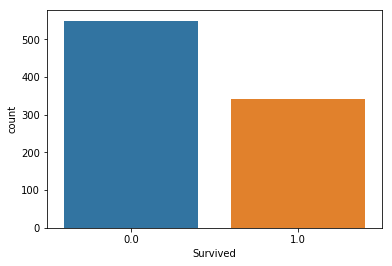

In [10]:
sns.countplot('Survived',data=combine_df)

In [11]:
combine_df.Survived.value_counts(normalize=True)

0.0    0.616162
1.0    0.383838
Name: Survived, dtype: float64

61.62% of the pessengers in training set died. This is slightly less than the estimated 67% that died in the actual shipwreck (1500/2224).

Accuracy(training data) of majority class prediction model is 61.62%

#### <a id="pclass">1.2 Pclass</a>

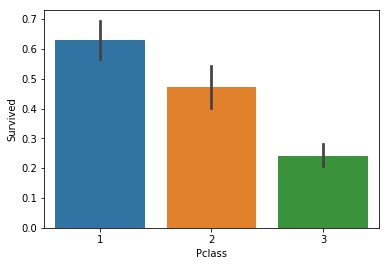

In [12]:
sns.barplot('Pclass','Survived',data=combine_df)

Class played a critical role in survival, as the survival rate decreased drastically for the lowest class. This variable is both useful and clean.

#### <a id="sex">1.3 Sex</a>

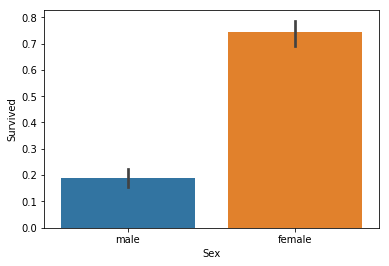

In [13]:
sns.barplot('Sex','Survived',data=combine_df)

Females have a much higher survival rate than males. Sex seems like an important feature.

#### <a id="name">1.4 Name</a>

I will create a new predictor, based on the value of the Name column, which always contain the person’s honorific title. Less frequent titles will be grouped in a new Title category named Noble.

In [14]:
combine_df['Title']=combine_df.Name.str.extract(' ([A-Za-z]+)\.',expand=False)

In [15]:
combine_df.Title.value_counts()

Mr          757
Miss        260
Mrs         197
Master       61
Dr            8
Rev           8
Col           4
Major         2
Ms            2
Mlle          2
Countess      1
Lady          1
Sir           1
Dona          1
Capt          1
Mme           1
Jonkheer      1
Don           1
Name: Title, dtype: int64

In [16]:
combine_df['Title'] = combine_df['Title'].replace(['Capt', 'Col', 'Dr', 'Major', 'Rev', 'Sir'], 'Noble')

combine_df['Title'] = combine_df['Title'].replace(['Mlle', 'Ms'], 'Miss')
combine_df['Title'] = combine_df['Title'].replace(['Mme', 'Dona','Countess','Lady'], 'Mrs')
combine_df['Title'] = combine_df['Title'].replace(['Don','Jonkheer'],'Mr')

In [17]:
combine_df.Survived.groupby(combine_df.Title).agg(['mean','count'])

,mean,count
Title,,
Master,0.575000,40
Miss,0.702703,185
Mr,0.156069,519
Mrs,0.796875,128
Noble,0.315789,19


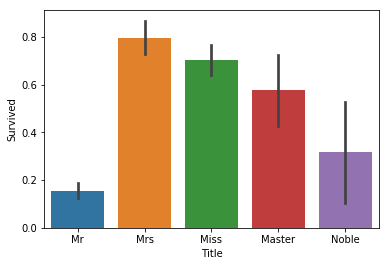

In [18]:
sns.barplot('Title','Survived',data=combine_df)

Surnames can be used to find family members.

Turns out grouping family and friends is an important feature.

In [19]:
combine_df['Surnames']=combine_df.Name.str.extract('([A-Za-z]+),',expand=False)

In [20]:
print("Numbers of unique surnames is",combine_df.Surnames.unique().size)

Numbers of unique surnames is 872


#### <a id="familysize">1.5 Family Size</a>

In [21]:
combine_df['FamilySize']=combine_df['Parch']+combine_df['SibSp']+1

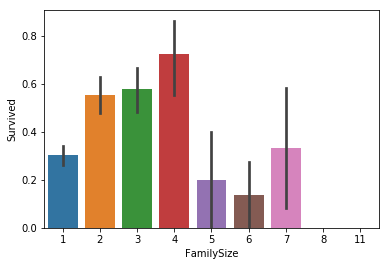

In [22]:
sns.barplot('FamilySize','Survived',data=combine_df)

We can see that there’s a survival penalty to singletons and those with family sizes above 4. We can collapse this variable into three levels which will be helpful since there are comparatively fewer large families. Let’s create a discretized family size variable.

In [23]:
def familySize2Levels(fsize):
    if fsize==1: return 'singleton'
    elif fsize<5: return 'small'
    else: return 'large'

In [24]:
combine_df['FamilySizeD']=combine_df.FamilySize.apply(familySize2Levels)

(<Figure size 432x288 with 3 Axes>,
 OrderedDict([(('small', '0.0'),
               (0.0, 0.0, 0.3244768921336578, 0.4198334319391981)),
              (('small', '1.0'),
               (0.0,
                0.42315569107541073,
                0.3244768921336578,
                0.5768443089245892)),
              (('singleton', '0.0'),
               (0.3294273871831628,
                0.0,
                0.5967263393005967,
                0.6941479982924702)),
              (('singleton', '1.0'),
               (0.3294273871831628,
                0.6974702574286827,
                0.5967263393005967,
                0.30252974257131715)),
              (('large', '0.0'),
               (0.9311042215332644,
                0.0,
                0.06889577846673557,
                0.8359232665309184)),
              (('large', '1.0'),
               (0.9311042215332644,
                0.839245525667131,
                0.06889577846673557,
                0.16075447433286888))]))

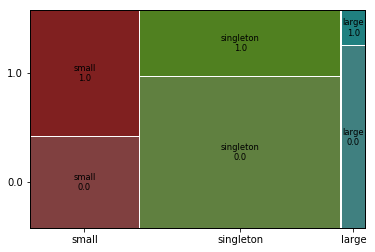

In [25]:
mosaicplot.mosaic(combine_df,['FamilySizeD','Survived'])

The mosaic plot shows that we preserve our rule that there’s a survival penalty among singletons and large families, but a benefit for passengers in small families. 

#### <a id="embarked">1.6 Embarked</a>

Two passengers missing data in this column. I think it is best to google the missing values.

In [26]:
combine_df[combine_df.Embarked.isna()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surnames,FamilySize,FamilySizeD
PassengerId,,,,,,,,,,,,,,,
62,38.0,B28,NaN,80.0,"Icard, Miss. Amelie",0,1,female,0,1.0,113572,Miss,Icard,1,singleton
830,62.0,B28,NaN,80.0,"Stone, Mrs. George Nelson (Martha Evelyn)",0,1,female,0,1.0,113572,Mrs,Stone,1,singleton


According to https://www.encyclopedia-titanica.org, both of them embarked from Southampton.

In [27]:
combine_df.loc[[62,830],'Embarked']='S'

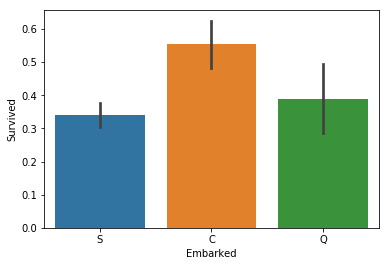

In [28]:
sns.barplot('Embarked','Survived',data=combine_df)

#### <a id="age">1.7 Age</a>

In [29]:
combine_df['Survived'].groupby(combine_df['Age'].isnull()).mean()

Age
False    0.406162
True     0.293785
Name: Survived, dtype: float64

There are 177 nulls for Age, and they have a 10% lower survival rate than the non-nulls. Before imputing values for the nulls, I will set an Age_null flag just to make sure we can account for this characteristic of the data.

In [30]:
combine_df['Age_Null_Flag'] = combine_df['Age'].apply(lambda age: 1 if pd.isnull(age) else 0)

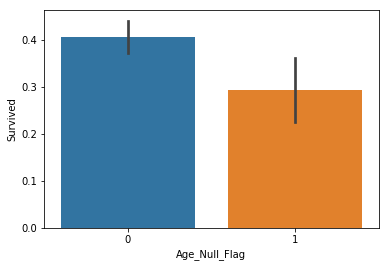

In [31]:
sns.barplot('Age_Null_Flag','Survived',data=combine_df)

We have higher chance of knowing the age of those who survived than those who didn't make it. So, this feature can be useful to have.

<u>Imputing age column</u>

In [32]:
val=combine_df.Age.groupby([combine_df.Sex,combine_df.Title,combine_df.Pclass]).transform('median')
combine_df['Age']=combine_df.Age.fillna(val)

Now that we know everyone’s age, we can create a couple of new age-dependent variables: Child and Mother. A child will simply be someone under 18 years of age and a mother is a passenger who is 1) female, 2) is over 18, 3) has more than 0 children (no kidding!), and 4) does not have the title ‘Miss’.

In [33]:
combine_df['IsChild']=False
combine_df['IsChild']=combine_df.Age.apply(lambda age: True if age<18 else False)

In [34]:
combine_df.Survived.groupby(combine_df.IsChild).agg(['mean','count'])

,mean,count
IsChild,,
False,0.360465,774
True,0.538462,117


Looks like being a child doesn’t hurt, but it’s not going to necessarily save you either! We will finish off our feature engineering by creating the Mother variable. Maybe we can hope that mothers are more likely to have survived on the Titanic.

In [35]:
combine_df['IsMother']=False
combine_df.loc[(combine_df.Sex=='female')&(combine_df.Parch>0)&(combine_df.Age>18)&(combine_df.Title!='Miss'),'IsMother']=True

In [36]:
combine_df.Survived.groupby(combine_df.IsMother).agg(['mean','count'])

,mean,count
IsMother,,
False,0.362440,836
True,0.709091,55


#### <a id="cabin">1.8 Cabin</a>

This variable appears to have a lot of missing values. So, I will not be imputing this column. But finding out the deck information may be useful.

In [37]:
combine_df.Cabin.unique()

array([nan, 'C85', 'C123', 'E46', 'G6', 'C103', 'D56', 'A6',
       'C23 C25 C27', 'B78', 'D33', 'B30', 'C52', 'B28', 'C83', 'F33',
       'F G73', 'E31', 'A5', 'D10 D12', 'D26', 'C110', 'B58 B60', 'E101',
       'F E69', 'D47', 'B86', 'F2', 'C2', 'E33', 'B19', 'A7', 'C49', 'F4',
       'A32', 'B4', 'B80', 'A31', 'D36', 'D15', 'C93', 'C78', 'D35',
       'C87', 'B77', 'E67', 'B94', 'C125', 'C99', 'C118', 'D7', 'A19',
       'B49', 'D', 'C22 C26', 'C106', 'C65', 'E36', 'C54',
       'B57 B59 B63 B66', 'C7', 'E34', 'C32', 'B18', 'C124', 'C91', 'E40',
       'T', 'C128', 'D37', 'B35', 'E50', 'C82', 'B96 B98', 'E10', 'E44',
       'A34', 'C104', 'C111', 'C92', 'E38', 'D21', 'E12', 'E63', 'A14',
       'B37', 'C30', 'D20', 'B79', 'E25', 'D46', 'B73', 'C95', 'B38',
       'B39', 'B22', 'C86', 'C70', 'A16', 'C101', 'C68', 'A10', 'E68',
       'B41', 'A20', 'D19', 'D50', 'D9', 'A23', 'B50', 'A26', 'D48',
       'E58', 'C126', 'B71', 'B51 B53 B55', 'D49', 'B5', 'B20', 'F G63',
       'C62 C64',

In [38]:
# The first character is the deck.

In [39]:
combine_df['Deck']=combine_df.Cabin.apply(lambda c: 'N' if pd.isnull(c) else c[0])

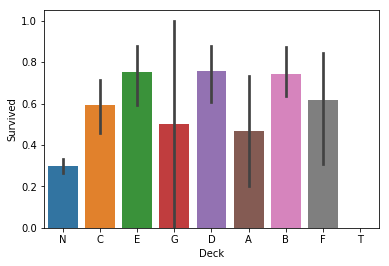

In [40]:
sns.barplot('Deck','Survived',data=combine_df)

#### <a id="fare">1.9 Fare</a>

In [41]:
combine_df[combine_df.Fare.isnull()]

,Age,Cabin,Embarked,Fare,Name,Parch,Pclass,Sex,SibSp,Survived,Ticket,Title,Surnames,FamilySize,FamilySizeD,Age_Null_Flag,IsChild,IsMother,Deck
PassengerId,,,,,,,,,,,,,,,,,,,
1044,60.5,NaN,S,NaN,"Storey, Mr. Thomas",0,3,male,0,NaN,3701,Mr,Storey,1,singleton,0,False,False,N


This is a third class passenger who departed from Southampton (‘S’). Let’s visualize Fares among all others sharing their class and embarkment.

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:454: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X>clip[0], X<clip[1])] # won't work for two columns.


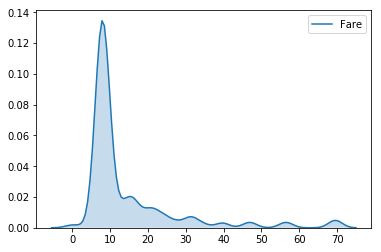

In [42]:
sns.kdeplot(combine_df[(combine_df.Pclass==3)&(combine_df.Embarked=='S')]['Fare'],shade=True)

In [43]:
combine_df[(combine_df.Pclass==3)&(combine_df.Embarked=='S')]['Fare'].median()

8.05

From this visualization, it seems quite reasonable to replace the NA Fare value with median for their class and embarkment which is $8.05.

In [44]:
combine_df.loc[1044,'Fare']=8.05

#### <a id="efi">1.10 Extracting family information</a>

First we can use last name to divide the passengers into families. And if you closely examin the data, same family are paying the same fare for the tickets. This suggests the fare is for the family. We can use both last name and fare to grout passengers into families in case different families with the same last name.

In [45]:
# The Fare is actually for the whole family
fare_df = combine_df.loc[combine_df['FamilySize']>1, ["Surnames", "Fare", "FamilySize"]]

In [46]:
fare_diff = (((fare_df.groupby(['Surnames', 'FamilySize']).max() 
               - fare_df.groupby(['Surnames', 'FamilySize']).min())!=0).sum()/len(combine_df) * 100)

print(("Percentage of families with different fares is: %.1f" %(fare_diff.values[0])) + '%')

Percentage of families with different fares is: 1.2%


In [47]:
# The data shows only 1.2% has a different fare value between family memebers. It's some type of anomaly
# Will use last name and fare to group passengers into families
# First would like to show there is value in doing this

In [48]:
train_temp_df = combine_df.iloc[:891]
family_df_grpby = train_temp_df[train_temp_df['FamilySize']>1][
    ['Surnames', 'Fare', 'FamilySize', 'Survived']].groupby(['Surnames', 'Fare'])
family_df = pd.DataFrame(data=family_df_grpby.size(), columns=['Size'])
family_df['Survived total'] = family_df_grpby['Survived'].sum().astype(int)
family_df['FamilySize'] = family_df_grpby['FamilySize'].mean().astype(int)

In [49]:
family_df.head(10)

Size  Survived total  FamilySize
Surnames  Fare                                      
Abbott    20.2500      2               1           3
Abelson   24.0000      2               1           2
Ahlin     9.4750       1               0           2
Aks       9.3500       1               1           2
Allison   151.5500     3               1           4
Andersson 7.9250       1               1           7
          31.2750      7               0           7
Andrews   77.9583      1               1           2
Angle     26.0000      1               1           2
Appleton  51.4792      1               1           3

In [50]:
print("Whole family survived: %.1f" 
      %(100*len(family_df[family_df['Size']==family_df['Survived total'] ])/len(family_df))+'%') 

Whole family survived: 44.7%


In [51]:
print("Whole family perished: %.1f" 
      %(100*len(family_df[family_df['Survived total'] == 0])/len(family_df))+'%') 

Whole family perished: 35.7%


In [52]:
## Majority family either all perished or all survived, this means we can use this as one feature to 
## predict survival

In [53]:
# Now let's do the feature extraction
# Intialize all 'Family survival', meaning there is no information on if any family members survived. 
# This number can be tuned I guess but I will use it to start with.

In [54]:
combine_df['Family survival'] = 0.5   #Default value

for grp, grp_df in combine_df[['Survived','Name', 'Surnames', 'Fare', 
                           'SibSp', 'Parch', 'Age', 'Cabin']].groupby(['Surnames', 'Fare']):
    if (len(grp_df) != 1):   # A Family group is found.

        for PassID, row in grp_df.iterrows():
            ## Find out if any family memebers survived or not
            smax = grp_df.drop(PassID)['Survived'].max()
            smin = grp_df.drop(PassID)['Survived'].min()

            ## If any family memebers survived, put this feature as 1
            if (smax==1.0): combine_df.loc[PassID, 'Family survival'] = 1
            ## Otherwise if any family memebers perished, put this feature as 0
            elif (smin==0.0): combine_df.loc[PassID, 'Family survival'] = 0

In [55]:
print("Number of passenger with family survival information: " 
          +str(combine_df[combine_df['Family survival']!=0.5].shape[0]))

Number of passenger with family survival information: 421


#### <a id="bff">1.11 Extracting friends information</a>

In addtional to family, if you examin the data closely, you will see there are groups of people with same ticket number, and they pay the same fare. This suggests group of friends are travelling together. One will think these friends will help each other and will survive or perish at the same time. We will explore this informtion here.`

In [56]:
# First find out how many such groups exists that are not families and what is the chance of 
# passengers within the same group survive or perish together
train_temp_df = combine_df.iloc[:891]
ticket_grpby = train_temp_df.groupby('Ticket')
ticket_df = pd.DataFrame(data=ticket_grpby.size(), columns=['Size'])
ticket_df['Survived total'] = ticket_grpby['Survived'].sum().astype(int)
ticket_df['Not family'] = ticket_grpby['Surnames'].unique().apply(len)
#ticket_df['Pclass'] = ticket_grpby['Pclass'].median()
ticket_df = ticket_df[(ticket_df['Size'] > 1) & (ticket_df['Not family']>1)]
print('Number of groups in training set that is not family: '+ str(len(ticket_df)))
print(("Whole group perished: %.1f" %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==0]))) + '%')
print(("Whole group survived: %.1f" 
       %(100/len(ticket_df)*len(ticket_df[ticket_df['Survived total']==ticket_df['Size']]))) + '%')

Number of groups in training set that is not family: 44
Whole group perished: 29.5%
Whole group survived: 36.4%


In [57]:
## Looking at the output, one can see ~76% of group members stay together. So let's extract this feature.
## We will overload the 'Family survival' column instead of creating a seperate feature.
ticket_grpby = combine_df.groupby('Ticket')
for _, grp_df in ticket_grpby:
    if (len(grp_df) > 1):
        for PassID, row in grp_df.iterrows():
            if (row['Family survival']==0)|(row['Family survival']==0.5):
                smax = grp_df.drop(PassID)['Survived'].max()
                smin = grp_df.drop(PassID)['Survived'].min()
                if (smax==1.0): combine_df.loc[PassID, 'Family survival'] = 1
                elif (smin==0.0): combine_df.loc[PassID, 'Family survival'] = 0
print("Number of passenger with family/group survival information: " 
      +str(combine_df[combine_df['Family survival']!=0.5].shape[0]))

Number of passenger with family/group survival information: 547


Good, we can see 546 passengers have a family/group survival information. That's a sizable chunk out of the total numbers of passengers. Hopefully it will improve our prediction accuracy

### <a id="prediction">2. Prediction</a>

I have tried  Ridge Logistic Regression, Decision Tree, KNeighborsClassifier and Random Forest. With Random Forest classifier I got the highest accuracy and, therefore only Random Forest Classifier is shown here.

At last we’re ready to predict who survives among passengers of the Titanic based on variables that we carefully curated and treated for missing values. First remove unnecessary columns such as Name column.

In [58]:
combine_df.columns

Index(['Age', 'Cabin', 'Embarked', 'Fare', 'Name', 'Parch', 'Pclass', 'Sex',
       'SibSp', 'Survived', 'Ticket', 'Title', 'Surnames', 'FamilySize',
       'FamilySizeD', 'Age_Null_Flag', 'IsChild', 'IsMother', 'Deck',
       'Family survival'],
      dtype='object')

In [59]:
combine_df=combine_df[['Age','Embarked','Fare','Parch','Pclass','Sex','SibSp','Survived',
                       'Title','Age_Null_Flag','IsChild','IsMother','Deck','FamilySizeD',
                      'Family survival']]

In [60]:
combine_df=pd.get_dummies(combine_df,
    prefix=['Family survival','Embarked','Pclass','Sex','Title','Age_Null_Flag','IsChild','IsMother','Deck','FamilySizeD'],
    columns=['Family survival','Embarked','Pclass','Sex','Title','Age_Null_Flag','IsChild','IsMother','Deck','FamilySizeD'])

In [61]:
train_df=combine_df[:891]
test_df=combine_df[891:].drop(columns='Survived')

In [62]:
train_df['Survived'] = train_df.Survived.astype('int')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [63]:
train_df['Survived'] = train_df.Survived.astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [64]:
def select_best_random_forest(X,Y):
    '''
    This helper fuction uses 10-fold CV to select best value of number of trees, maximum depth of
    the tree and minimum number of samples required to split the node.
    '''
    param_grid = {'n_estimators':[i for i in range(1,21)],
                 'max_depth':[i for i in range(2,21)],
                 'min_samples_split':[i for i in range(2,21)]}
    rfc=RandomForestClassifier(max_features=None,random_state=354)
    gsc = GridSearchCV(rfc, param_grid,scoring='accuracy',cv=10,n_jobs=4)
    gsc.fit(X,Y)
    return gsc,gsc.best_params_,gsc.best_score_

In [65]:
X=train_df.drop(columns='Survived')
Y=train_df['Survived']

In [66]:
gsc,best_parameter,best_score=select_best_random_forest(X,Y)
print(best_score)
best_parameter

0.8597081930415263


{'max_depth': 4, 'min_samples_split': 13, 'n_estimators': 9}

In [67]:
rfc=RandomForestClassifier(max_depth=4,min_samples_split=9,n_estimators=11,max_features=None,random_state=354)
rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=9,
            min_weight_fraction_leaf=0.0, n_estimators=11, n_jobs=1,
            oob_score=False, random_state=354, verbose=0, warm_start=False)

In [68]:
training_score=rfc.score(X,Y)
training_score

0.8664421997755332

In [69]:
# Creating DF of features and its weights based on above training.
# feat is sort for features
feat = pd.DataFrame({
        "Features": X.columns.values,
        "Weights": rfc.feature_importances_
    })

feat['Weights']=feat.Weights*100   #Because weights value are very small, multiplying by 100 will make the table look nice.

feat.sort_values('Weights',ascending=False)

,Features,Weights
17,Title_Mr,39.565131
4,Family survival_0.0,12.482169
14,Sex_male,9.919073
1,Fare,6.982241
12,Pclass_3,6.802515
13,Sex_female,5.044051
0,Age,4.224715
35,FamilySizeD_large,2.943405
19,Title_Noble,2.745877
33,Deck_N,2.531545


In [70]:
# Remove the features with very small weights.
dropfeat=feat[feat.Weights<0.1]['Features'].values.tolist()

#### <a id="pusf">2.1 Prediction using selected features</a>

In [71]:
combine_df=combine_df.drop(columns=dropfeat)

In [72]:
train_df=combine_df[:891]
test_df=combine_df[891:].drop(columns='Survived')

In [73]:
train_df['Survived'] = train_df.Survived.astype('int')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [74]:
train_df['Survived'] = train_df.Survived.astype('category')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [75]:
X=train_df.drop(columns='Survived')
Y=train_df['Survived']

In [76]:
gsc,best_parameter,best_score=select_best_random_forest(X,Y)
print(best_score)
best_parameter

0.8619528619528619


{'max_depth': 4, 'min_samples_split': 2, 'n_estimators': 7}

In [77]:
rfc=RandomForestClassifier(max_depth=4,min_samples_split=2,n_estimators=7,max_features=None,random_state=354)
rfc.fit(X,Y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=4, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=7, n_jobs=1,
            oob_score=False, random_state=354, verbose=0, warm_start=False)

In [78]:
training_score=rfc.score(X,Y)
training_score

0.8686868686868687

In [79]:
test_Survived = pd.Series(rfc.predict(test_df), name="Survived")

submission = pd.DataFrame({
        "PassengerId": test_df.index.values,
        "Survived": test_Survived
    })

submission.to_csv(r"D:\kaggle\titanic\submission.csv", index=False)